Все модели обучаются и тестируются на одних и тех же датасетах.

In [ ]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 40.8 MB/s eta 0:00:00


In [ ]:
pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=879172 sha256=66bb0d314521e56f8eafd985d20eaccfbfd994ce6fc1c46c3eff6b6282ff9b30
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
import gc
import pandas as pd
import numpy as np
import tqdm
from scipy.sparse import csr_matrix, coo_matrix

from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import recall_at_k, precision_at_k, auc_score
import lightgbm as lgbm

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k, ndcg_at_k, AUC_at_k

# Подготовка

## Данные

In [ ]:
path = "/content/drive/MyDrive/WB School/data.csv.gzip"
interactions = pd.read_csv(path, compression="gzip")
interactions["order_ts"] = pd.to_datetime(interactions["order_ts"])

2 месяца отнесём в обучающую выборку, последний месяц - в тестовую:

In [ ]:
train = interactions[interactions.order_ts <= "2023-02-28 23:59:59.947831"]
test = interactions[interactions.order_ts > "2023-02-28 23:59:59.947831"]

del interactions
gc.collect()

Оставим в тестовой выборке только тех пользователей и те товары, которые информация о взаимодействиях которых (с которыми) есть в обучающей выборке:

In [ ]:
test = test[test["user_id"].isin(train["user_id"].unique())]
test = test[test["item_id"].isin(train["item_id"].unique())]

In [ ]:
train = train.drop_duplicates()
test = test.drop_duplicates()

Приведём данные к необходимому для библиотек формату:

In [ ]:
user_ids_buffered = (x for x in train["user_id"].unique())
item_ids_buffered = (x for x in train["item_id"].unique())

In [ ]:
dataset = Dataset()
dataset.fit(
  users=user_ids_buffered,
  items=item_ids_buffered
)

In [ ]:
train = train.groupby(["user_id", "item_id"], as_index=False).count().rename(columns={"order_ts": "amount"})
test = test.groupby(["user_id", "item_id"], as_index=False).count().rename(columns={"order_ts": "amount"})

In [ ]:
def transform_interactions(interactions):
  return interactions[["user_id", "item_id", "amount"]].itertuples(index=False)

In [ ]:
interaction_matrix_train, _ = dataset.build_interactions(
    transform_interactions(train))

In [ ]:
interaction_matrix_test, _ = dataset.build_interactions(
    transform_interactions(test))

Проверка:

In [ ]:
interaction_matrix_train.shape, interaction_matrix_test.shape

## Функции

В LightFM нет функции для вычисления nDCG@K, поэтому подготовим функцию для этого.

In [ ]:
def ndcg_at_k_custom(users_ranks, users_relevances, k=20):

  if len(users_ranks) != len(users_relevances):
    raise ValueError("Размеры ranks и relevance должны быть одинаковыми.")

  ndcg = 0
  n = 0

  for i in tqdm(range(len(users_ranks))):

    ranks = np.array(users_ranks[i][:k])
    relevance = np.array(users_relevances[i][:k])

    if relevance.sum() != 0:

      n += 1

      sorted_indices = np.argsort(relevance)[::-1]
      sorted_ranks = ranks[sorted_indices]
      sorted_relevance = relevance[sorted_indices]

      sorted_indices = sorted_indices[:k]
      sorted_ranks = sorted_ranks[:k]
      sorted_relevance = sorted_relevance[:k]

      ideal_relevance = np.sort(sorted_relevance)[::-1]

      dcg = np.sum((2**sorted_relevance - 1) / np.log2(sorted_ranks + 1))

      idcg = np.sum((2**ideal_relevance - 1) / np.log2(np.arange(2, len(ideal_relevance) + 2)))

      # Вычисление ndcg
      ndcg_value = dcg / idcg

      ndcg += ndcg_value

  mean_ndcg = ndcg / n

  return mean_ndcg, n

# Baseline - ALS

In [ ]:
model_ALS = AlternatingLeastSquares(factors=40,
                                    iterations=20,
                                    regularization=0.00003,
                                    alpha=6)
model_ALS.fit(interaction_matrix_train)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.5579063892364502 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
def compute_implicit_metrics(model, train_csr, test_csr, K=20):

  ndcg_score = ndcg_at_k(model=model,
                         train_user_items=train_csr,
                         test_user_items=test_csr,
                         K=K,
                         show_progress=False)

  print("NDCG@" + str(K) + ": " + str(ndcg_score))

  map_score = mean_average_precision_at_k(model=model,
                                          train_user_items=train_csr,
                                          test_user_items=test_csr,
                                          K=K,
                                          show_progress=False)

  print("MAP@" + str(K) + ": " + str(map_score))

  auc_score = AUC_at_k(model=model,
                       train_user_items=train_csr,
                       test_user_items=test_csr,
                       K=K,
                       show_progress=False)

  print("AUC" + ": " + str(auc_score))

In [ ]:
compute_implicit_metrics(model_ALS, interaction_matrix_train, interaction_matrix_test)

NDCG@20: 0.07799193579648375
MAP@20: 0.031611685860117686
AUC: 0.550356466518696


# LightFM-модели

## Обучение

Сначала обучим модели:

In [ ]:
model_warp_kos = LightFM(
    no_components=40,
    k=3,
    n=11,
    learning_schedule="adagrad",
    loss="warp-kos",
    learning_rate=0.027,
    item_alpha=0.00001,
    user_alpha=0.00014,
    max_sampled=42)

model_warp_kos.fit(interaction_matrix_train, epochs=20)

In [ ]:
model_lmf = LightFM(
    no_components=40,
    learning_schedule="adagrad",
    loss="logistic",
    learning_rate=0.019,
    item_alpha=0.0001,
    user_alpha=0.00001
)

model_lmf.fit(interaction_matrix_train, epochs=20)

In [ ]:
model_bpr = LightFM(
    no_components=40,
    learning_schedule="adagrad",
    loss="bpr",
    learning_rate=0.035,
    item_alpha=0.00001,
    user_alpha=0.0001
)

model_bpr.fit(interaction_matrix_train, epochs = 20)

In [ ]:
model_warp = LightFM(
    no_components=40,
    learning_schedule="adagrad",
    loss="warp",
    learning_rate=0.04,
    item_alpha=0.0001,
    user_alpha=0.00005,
    max_sampled=40
)

model_warp.fit(interaction_matrix_train, epochs=20)

Занулим константы при скорах айтемов, т.к. происходит сильный перекос в сторону популярных товаров. Особенно это сказывается на результатах LMF и BPR.

In [ ]:
model_warp_kos.item_biases = np.zeros_like(model_warp_kos.item_biases)
model_bpr.item_biases = np.zeros_like(model_bpr.item_biases)
model_lmf.item_biases = np.zeros_like(model_lmf.item_biases)
model_warp.item_biases = np.zeros_like(model_warp.item_biases)

## Метрики из LightFM

Для удобства соберём функцию с метриками, реализованными в самой LightFM:

In [ ]:
def compute_lightfm_metrics(model, test_csr, K=20):

  mar_score = recall_at_k(
      model=model,
      test_interactions=test_csr,
      k=K).mean()

  print("MAR@" + str(K) + ": " + str(mar_score))

  map_score = precision_at_k(
      model=model,
      test_interactions=test_csr,
      k=K).mean()

  print("MAP@" + str(K) + ": " + str(map_score))

  auc = auc_score(
      model=model,
      test_interactions=test_csr).mean()

  print("AUC" + ": " + str(auc))

In [ ]:
compute_lightfm_metrics(model_warp_kos, interaction_matrix_test)

MAR@20: 0.1911407042967994
MAP@20: 0.068257414
AUC: 0.9306624


In [ ]:
compute_lightfm_metrics(model_lmf, interaction_matrix_test)

In [ ]:
compute_lightfm_metrics(model_bpr, interaction_matrix_test)

MAR@20: 0.18752204383479343
MAP@20: 0.06689085
AUC: 0.6460498


In [ ]:
compute_lightfm_metrics(model_warp, interaction_matrix_test)

MAR@20: 0.1977219490418296
MAP@20: 0.06926053
AUC: 0.93269706


## nDCG@K для LightFM моделей

Подготовим отображения товаров и пользователей:

In [ ]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {"users_mapping": lightfm_mapping[0],
                   "items_mapping": lightfm_mapping[2]}

lightfm_mapping["users_inv_mapping"] = {v: k for k, v in lightfm_mapping["users_mapping"].items()}
lightfm_mapping["items_inv_mapping"] = {v: k for k, v in lightfm_mapping["items_mapping"].items()}

all_cols = list(lightfm_mapping["items_mapping"].values())

Инициализируем функцию, с помощью которой будем отбирать кандидатов:

In [ ]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
  def _recs_mapper(user):
    user_id = user_mapping[user]
    recs = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features, num_threads=num_threads)

    additional_N = len(known_items[user_id]) if user_id in known_items else 0
    total_N = N + additional_N
    top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]

    final_recs = [item_inv_mapping[item] for item in top_cols]
    if additional_N > 0:
        filter_items = known_items[user_id]
        final_recs = [item for item in final_recs if item not in filter_items]
    return final_recs[:N]
  return _recs_mapper

Будем считать nDCG@20, поэтому возьмём по 20 товаров для каждого пользователя.

In [ ]:
def extract_candidates(train, test, model, lightfm_mapping, top_N=20):

  if model == "warp":

    prediction = pd.DataFrame({"user_id": test["user_id"].unique()})
    prediction = prediction[prediction["user_id"].isin(train["user_id"].unique())]
    known_items = train.groupby("user_id")["item_id"].apply(list).to_dict()

    all_cols = list(lightfm_mapping["items_mapping"].values())

    mapper = generate_lightfm_recs_mapper(
        model_warp,
        item_ids=all_cols,
        known_items=known_items,
        N=top_N,
        user_features=None,
        item_features=None,
        user_mapping=lightfm_mapping["users_mapping"],
        item_inv_mapping=lightfm_mapping["items_inv_mapping"],
        num_threads=20
    )

    prediction["item_id"] = prediction["user_id"].map(mapper)
    prediction = prediction.explode("item_id").reset_index(drop=True)
    prediction["rank_warp"] = prediction.groupby("user_id").cumcount() + 1

  elif model == "lmf":

    prediction = pd.DataFrame({"user_id": test["user_id"].unique()})
    prediction = prediction[prediction["user_id"].isin(train["user_id"].unique())]
    known_items = train.groupby("user_id")["item_id"].apply(list).to_dict()

    all_cols = list(lightfm_mapping["items_mapping"].values())

    mapper = generate_lightfm_recs_mapper(
        model_lmf,
        item_ids=all_cols,
        known_items=known_items,
        N=top_N,
        user_features=None,
        item_features=None,
        user_mapping=lightfm_mapping["users_mapping"],
        item_inv_mapping=lightfm_mapping["items_inv_mapping"],
        num_threads=20
    )

    prediction["item_id"] = prediction["user_id"].map(mapper)
    prediction = prediction.explode("item_id").reset_index(drop=True)
    prediction["rank_lmf"] = prediction.groupby("user_id").cumcount() + 1

  elif model == "bpr":

    prediction = pd.DataFrame({"user_id": test["user_id"].unique()})
    prediction = prediction[prediction["user_id"].isin(train["user_id"].unique())]
    known_items = train.groupby("user_id")["item_id"].apply(list).to_dict()

    all_cols = list(lightfm_mapping["items_mapping"].values())

    mapper = generate_lightfm_recs_mapper(
        model_bpr,
        item_ids=all_cols,
        known_items=known_items,
        N=top_N,
        user_features=None,
        item_features=None,
        user_mapping=lightfm_mapping["users_mapping"],
        item_inv_mapping=lightfm_mapping["items_inv_mapping"],
        num_threads=20
    )

    prediction["item_id"] = prediction["user_id"].map(mapper)
    prediction = prediction.explode("item_id").reset_index(drop=True)
    prediction["rank_bpr"] = prediction.groupby("user_id").cumcount() + 1

  elif model == "warp_kos":

    prediction = pd.DataFrame({"user_id": test["user_id"].unique()})
    prediction = prediction[prediction["user_id"].isin(train["user_id"].unique())]
    known_items = train.groupby("user_id")["item_id"].apply(list).to_dict()

    all_cols = list(lightfm_mapping["items_mapping"].values())

    mapper = generate_lightfm_recs_mapper(
        model_warp_kos,
        item_ids=all_cols,
        known_items=known_items,
        N=top_N,
        user_features=None,
        item_features=None,
        user_mapping=lightfm_mapping["users_mapping"],
        item_inv_mapping=lightfm_mapping["items_inv_mapping"],
        num_threads=20
    )

    prediction["item_id"] = prediction["user_id"].map(mapper)
    prediction = prediction.explode("item_id").reset_index(drop=True)
    prediction["rank_warp_kos"] = prediction.groupby("user_id").cumcount() + 1

  else:

    print("Возможно 4 варианта моделей: warp, bpr, lmf и warp_kos.")

Как правило, составление отображения занимает 30 минут, поэтому лучше запускать последовательно (поэтому остальные 3 закоменчены):

In [ ]:
prediction = extract_candidates(train, test, "warp", lightfm_mapping)
# prediction = extract_candidates(train, test, "bpr", lightfm_mapping)
# prediction = extract_candidates(train, test, "lmf", lightfm_mapping)
# prediction = extract_candidates(train, test, "warp_kos", lightfm_mapping)

Проверим, всем ли пользователям порекомендовалось 20 товаров.

In [ ]:
prediction.user_id.value_counts(normalize=True)

Добавим колонку со значениями релевантности, где 1 соответствует тому, что в тестовом периоде пользователь с товаром **взаимодействовал**.

In [ ]:
test = test.drop(columns="amount")
test["relevance"] = 1
prediction = pd.merge(prediction, test, on=["user_id", "item_id"], how="left")
prediction["relevance"] = prediction["relevance"].fillna(0)
prediction["relevance"] = prediction["relevance"].astype(int)

Посмотрим на соотношение:

In [ ]:
prediction.relevance.value_counts(normalize=True)

Достанем ранги, проставленные моделью, и соответствующие значения релевантности:

In [ ]:
ranks = prediction.groupby("user_id")["rank_warp"].apply(list).values
relevances = prediction.groupby("user_id")["relevance"].apply(list).values

Проверка:

In [ ]:
len(ranks) ==  len(relevances)

Посчитаем nDCG@K с помощью функции, инициализированной выше:

In [ ]:
ndcg_at_k_custom(
    users_ranks=ranks,
    users_relevances=relevances,
    k=20
)

# Top-Recommender

Для модели, рекомендующей товары на основе их популярности, не надо преобразовывать данные как для остальных моделей, поэтому заново инициализируем исходные данные:

In [ ]:
path = "/content/drive/MyDrive/WB School/data.csv.gzip"
interactions = pd.read_csv(path, compression="gzip")
interactions["order_ts"] = pd.to_datetime(interactions["order_ts"])

In [ ]:
train = interactions[interactions.order_ts <= "2023-02-28 23:59:59.947831"]
test = interactions[interactions.order_ts > "2023-02-28 23:59:59.947831"]

del interactions
gc.collect()

In [ ]:
test = test[test["user_id"].isin(train["user_id"].unique())]
test = test[test["item_id"].isin(train["item_id"].unique())]

train = train.drop_duplicates()
test = test.drop_duplicates()

Для всех пользователей будут рекомендоваться самые популярные за 2 обучающих месяца товары. Забираем 20 наиболее популярных товаров.

In [ ]:
train = train.drop(columns="order_ts").groupby("item_id", as_index=False).count().rename(columns={"user_id": "amount"}).sort_values("amount", ascending=False)
items = train.item_id.values[:20]

Для расчёта nDCG@K добавим значения релевантности:

In [ ]:
test = test.groupby(["user_id", "item_id"], as_index=False).count().rename(columns={"order_ts": "amount"})
test = test.drop(columns="amount")
test["relevance"] = 1

Проранжируем рекомендуемые товары:

In [ ]:
prediction = pd.DataFrame({"user_id": test["user_id"].unique()})
prediction["item_id"] = [items for i in prediction.index]
prediction = prediction.explode("item_id").reset_index(drop=True)
prediction["rank_pop"] = prediction.groupby("user_id").cumcount() + 1

Соберём данные:

In [ ]:
prediction = pd.merge(prediction, test, on=["user_id", "item_id"], how="left")
prediction["relevance"] = prediction["relevance"].fillna(0)
prediction["relevance"] = prediction["relevance"].astype(int)

Посмотрим на соотношение positive и negative:

In [ ]:
prediction.relevance.value_counts(normalize=True)

0    0.931309
1    0.068691
Name: relevance, dtype: float64

Достанем ранги и релевантности:

In [ ]:
ranks = prediction.groupby("user_id")["rank_pop"].apply(list).values
relevances = prediction.groupby("user_id")["relevance"].apply(list).values

Наконец, посчитаем значение метрики nDCG@20:

In [ ]:
ndcg_at_k_custom(
    users_ranks=ranks,
    users_relevances=relevances,
    k=20
)

100%|██████████| 720401/720401 [00:29<00:00, 24312.38it/s]


0.5045415311383252

# nDCG@K для гибридной модели

In [ ]:
from numpy import load

Подгрузим полученные заранее ранги и релевантности гибридной модели

In [ ]:
lgbm_ranks = load("/content/drive/MyDrive/WB School/L4/lgbm_ranks.npy", allow_pickle=True)
lgbm_relevances = load("/content/drive/MyDrive/WB School/L4/lgbm_relevances.npy", allow_pickle=True)

In [ ]:
ndcg_at_k_custom(
    users_ranks=lgbm_ranks,
    users_relevances=lgbm_relevances,
    k=20
)

100%|██████████| 726266/726266 [00:25<00:00, 28246.71it/s]


In [ ]:
ndcg, n

(0.5077892906497211, 426451)

# Итоги

Качество моделей получилось следующим: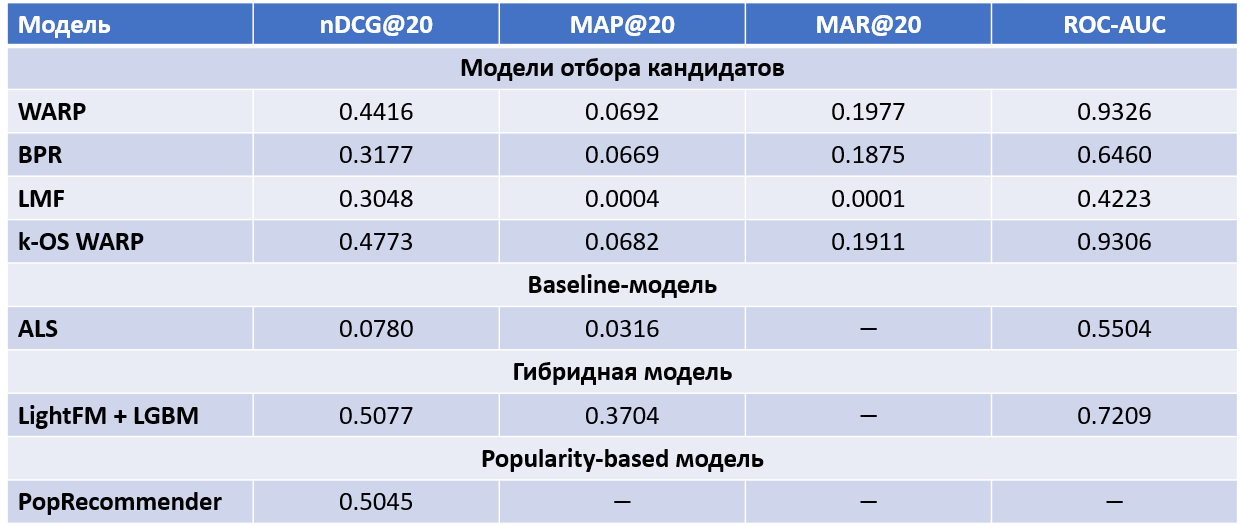

Разнообразие:

Идея для конструирования train и test датасетов в нужном формате: https://www.kaggle.com/code/parthplc/interview-building-recommendation-system-lightfm